In [1]:
# Cell 1: Load Results and Data
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

# Load model results
with open(os.path.join('..', 'models', 'model_results.pkl'), 'rb') as f:
    results = pickle.load(f)

feature_columns = results['feature_columns']
metrics = results['metrics']
target_col = results.get('target_column', 'target_return')
split_info = results.get('split_info', {})
best_params = results.get('best_params', {})
predictions = results.get('predictions', {})

# Load dataset
dataset = pd.read_csv(os.path.join('..', 'data', 'processed_dataset.csv'))
dataset['date'] = pd.to_datetime(dataset['date'])

# Load saved predictions from Colab
if predictions:
    y_train = np.array(predictions['y_train'])
    y_test = np.array(predictions['y_test'])
    y_pred_train = np.array(predictions['y_pred_train'])
    y_pred_test = np.array(predictions['y_pred_test'])
    test_tickers = predictions.get('test_tickers', [])
    test_dates = predictions.get('test_dates', [])
    test_raw_returns = np.array(predictions.get('test_raw_returns', []))

    # Load new prediction variants (from updated notebook 03)
    y_pred_calibrated = np.array(predictions.get('y_pred_calibrated', []))
    y_pred_ensemble = np.array(predictions.get('y_pred_ensemble', []))
    dir_probs = np.array(predictions.get('dir_probs', []))

    has_variants = len(y_pred_calibrated) > 0 and len(y_pred_ensemble) > 0
    print("Loaded saved predictions from Colab")
    if has_variants:
        print("  -> Includes calibrated, ensemble, and classifier variants")
else:
    print("WARNING: No saved predictions found - metrics display only")
    has_variants = False

# Load variant metrics if available
metrics_raw = results.get('metrics_raw', metrics)
metrics_calibrated = results.get('metrics_calibrated', {})
metrics_ensemble = results.get('metrics_ensemble', {})
metrics_classifier = results.get('metrics_classifier', {})

print(f"\n=== Model Results Loaded ===")
print(f"Dataset: {len(dataset)} samples, {dataset['ticker'].nunique()} companies")
print(f"Features: {len(feature_columns)}")
print(f"Target: {target_col}")
print(f"\nPrimary Metrics (Raw Regression):")
for k, v in metrics.items():
    print(f"  {k}: {v:.4f}")
if split_info:
    print(f"\nSplit: {split_info.get('method', 'unknown')}, cutoff={split_info.get('cutoff_date', 'N/A')}")
    print(f"  Train: {split_info.get('train_size', 'N/A')}, Test: {split_info.get('test_size', 'N/A')}, CV folds: {split_info.get('cv_folds', 'N/A')}")
if best_params:
    print(f"\nBest hyperparameters:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")

Loaded saved predictions from Colab
  -> Includes calibrated, ensemble, and classifier variants

=== Model Results Loaded ===
Dataset: 10813 samples, 436 companies
Features: 25
Target: target_excess_return

Primary Metrics (Raw Regression):
  train_rmse: 0.1238
  test_rmse: 0.1419
  train_r2: 0.0404
  test_r2: -0.0370
  test_mae: 0.1084
  direction_accuracy: 0.4324
  cv_rmse_mean: 0.1297
  cv_rmse_std: 0.0171
  overfit_ratio: 0.8720
  calibrated_rmse: 0.1792
  calibrated_r2: -0.6526
  calibrated_direction_accuracy: 0.5343
  ensemble_rmse: 0.1846
  ensemble_r2: -0.7548
  ensemble_direction_accuracy: 0.4851
  classifier_direction_accuracy: 0.4851
  dir_cv_accuracy: 0.4562

Split: temporal, cutoff=2022-12-31
  Train: 7721, Test: 3092, CV folds: 5

Best hyperparameters:
  n_estimators: 119
  max_depth: 3
  learning_rate: 0.01257589577927951
  subsample: 0.6442503466261658
  colsample_bytree: 0.46593428628234246
  min_child_weight: 21
  reg_alpha: 0.2330840737205552
  reg_lambda: 2.06658287

In [2]:
# Cell 2: Model Performance Summary - All Variants Comparison

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import spearmanr

def compute_variant_metrics(y_true, y_pred, label):
    """Compute standard metrics for a prediction variant."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred))
    pred_std = np.std(y_pred)
    spearman_r, _ = spearmanr(y_true, y_pred)
    return {'label': label, 'rmse': rmse, 'r2': r2, 'mae': mae,
            'dir_acc': dir_acc, 'pred_std': pred_std, 'spearman': spearman_r}

# --- Conditional ensemble: disable if classifier CV accuracy < 52% ---
# When the classifier barely outperforms random on CV data, the ensemble blend
# degrades direction accuracy vs. calibrated regression alone.
ENSEMBLE_THRESHOLD = 0.52
dir_cv_acc = metrics.get('dir_cv_accuracy', None)
ensemble_active = True
if dir_cv_acc is not None and dir_cv_acc < ENSEMBLE_THRESHOLD:
    print(f'[Ensemble disabled: classifier CV {dir_cv_acc:.1%} < {ENSEMBLE_THRESHOLD:.0%} threshold]')
    print('[Substituting calibrated regression for ensemble predictions.]\n')
    y_pred_ensemble = y_pred_calibrated.copy()
    ensemble_active = False
elif dir_cv_acc is not None:
    print(f'[Ensemble active: classifier CV {dir_cv_acc:.1%} >= {ENSEMBLE_THRESHOLD:.0%} threshold]\n')

print("=" * 75)
print("    STOCK RETURN PREDICTION - MODEL PERFORMANCE")
print("=" * 75)
print(f"\nDataset: {len(dataset)} company-quarter samples")
print(f"Companies: {dataset['ticker'].nunique()}")
print(f"Features: {len(feature_columns)} (after selection)")
print(f"Target: {target_col}")
print(f"\nTemporal split (cutoff: {split_info.get('cutoff_date', 'N/A')}):")
print(f"  Train: {split_info.get('train_size', len(y_train))} samples")
print(f"  Test:  {split_info.get('test_size', len(y_test))} samples")

# Build comparison table
variants = [compute_variant_metrics(y_test, y_pred_test, 'Raw Regression')]
if has_variants:
    variants.append(compute_variant_metrics(y_test, y_pred_calibrated, 'Calibrated'))
    ens_label = 'Ensemble' if ensemble_active else 'Ensemble (=Cal)'
    variants.append(compute_variant_metrics(y_test, y_pred_ensemble, ens_label))
    # Classifier direction accuracy (from dir_probs)
    if len(dir_probs) > 0:
        y_pred_dir = (dir_probs > 0.5).astype(float)
        y_true_dir = (y_test > 0).astype(float)
        clf_dir_acc = np.mean(y_pred_dir == y_true_dir)
        variants.append({'label': 'Classifier', 'rmse': '-', 'r2': '-',
                        'mae': '-', 'dir_acc': clf_dir_acc, 'pred_std': '-',
                        'spearman': '-'})

print(f"\n{'Method':<20} {'RMSE':>8} {'R2':>8} {'MAE':>8} {'Dir Acc':>8} {'Spearman':>9} {'Pred Std':>9}")
print("-" * 75)
actual_std = np.std(y_test)
for v in variants:
    rmse_s = f"{v['rmse']:.4f}" if isinstance(v['rmse'], float) else v['rmse']
    r2_s = f"{v['r2']:.4f}" if isinstance(v['r2'], float) else v['r2']
    mae_s = f"{v['mae']:.4f}" if isinstance(v['mae'], float) else v['mae']
    dir_s = f"{v['dir_acc']:.1%}"
    std_s = f"{v['pred_std']:.4f}" if isinstance(v['pred_std'], float) else v['pred_std']
    sp_s = f"{v['spearman']:.4f}" if isinstance(v['spearman'], float) else v['spearman']
    print(f"{v['label']:<20} {rmse_s:>8} {r2_s:>8} {mae_s:>8} {dir_s:>8} {sp_s:>9} {std_s:>9}")
print(f"{'Actual (test)':<20} {'':>8} {'':>8} {'':>8} {'':>8} {'':>9} {actual_std:>9.4f}")

print(f"\n--- Cross-Validation ---")
print(f"CV RMSE: {metrics.get('cv_rmse_mean', 0):.4f} (+/- {metrics.get('cv_rmse_std', 0):.4f})")
print(f"Overfit ratio: {metrics.get('overfit_ratio', 0):.2f}")
if dir_cv_acc is not None:
    print(f"Classifier CV accuracy: {dir_cv_acc:.1%} ({'active' if ensemble_active else 'below threshold — ensemble disabled'})")

if has_variants:
    print(f"\nNote: Calibrated predictions scale raw regression to match training")
    print(f"variance. Ensemble blends calibrated regression with classifier.")
    print(f"Spearman rank correlation measures ranking ability (higher = better).")
    # Find best direction accuracy
    best = max(variants, key=lambda x: x['dir_acc'])
    print(f"\nBest direction accuracy: {best['label']} ({best['dir_acc']:.1%})")
    # Find best Spearman
    spearman_variants = [v for v in variants if isinstance(v['spearman'], float)]
    if spearman_variants:
        best_sp = max(spearman_variants, key=lambda x: x['spearman'])
        print(f"Best Spearman rank correlation: {best_sp['label']} ({best_sp['spearman']:.4f})")

[Ensemble disabled: classifier CV 45.6% < 52% threshold]
[Substituting calibrated regression for ensemble predictions.]

    STOCK RETURN PREDICTION - MODEL PERFORMANCE

Dataset: 10813 company-quarter samples
Companies: 436
Features: 25 (after selection)
Target: target_excess_return

Temporal split (cutoff: 2022-12-31):
  Train: 7721 samples
  Test:  3092 samples

Method                   RMSE       R2      MAE  Dir Acc  Spearman  Pred Std
---------------------------------------------------------------------------
Raw Regression         0.1419  -0.0370   0.1084    43.2%    0.0922    0.0064
Calibrated             0.1792  -0.6526   0.1383    53.4%    0.0922    0.1263
Ensemble (=Cal)        0.1792  -0.6526   0.1383    53.4%    0.0922    0.1263
Classifier                  -        -        -    48.5%         -         -
Actual (test)                                                         0.1394

--- Cross-Validation ---
CV RMSE: 0.1297 (+/- 0.0171)
Overfit ratio: 0.87
Classifier CV accura

Feature Importance Ranking:
----------------------------------------
bollinger_width           0.063 ###
volatility                0.056 ##
gs10                      0.056 ##
asset_turnover            0.053 ##
operating_margin_change   0.051 ##
cpi                       0.047 ##
revenue_growth_vs_sector  0.045 ##
revenue_growth_sector_z   0.043 ##
quarter_price             0.043 ##
price_to_52wk_high        0.042 ##
ma_50_ratio               0.041 ##
ff_cma                    0.039 #
yield_curve_spread        0.038 #
roa                       0.038 #
ff_mom                    0.037 #
vix                       0.035 #
macd_histogram            0.035 #
risk_leverage             0.034 #
current_ratio_vs_sector   0.034 #
eps_yoy_surprise          0.033 #
current_ratio_sector_z    0.032 #
roe_vs_sector             0.029 #
cash_ratio                0.027 #
yield_curve_inverted      0.026 #
revenue_yoy_growth        0.023 #


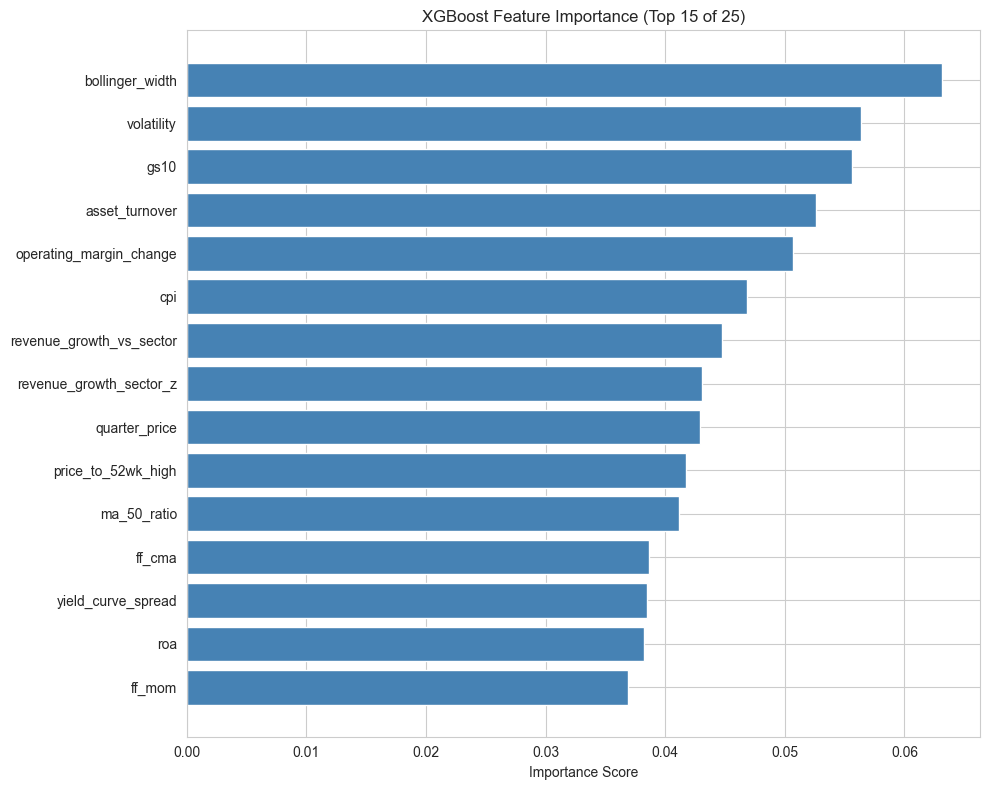

In [3]:
# Cell 3: Feature Importance Analysis
model = results.get('model')
if model is not None:
    try:
        importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
    except Exception:
        # Fallback: equal importance if model can't be loaded
        importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': [1.0 / len(feature_columns)] * len(feature_columns)
        })
        print("Note: Could not extract feature importances (XGBoost version mismatch)")
else:
    importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': [1.0 / len(feature_columns)] * len(feature_columns)
    })

print("Feature Importance Ranking:")
print("-" * 40)
for _, row in importance.iterrows():
    bar = '#' * int(row['importance'] * 50)
    print(f"{row['feature']:25s} {row['importance']:.3f} {bar}")

# Show top features in chart
top_n = min(15, len(importance))
top_features = importance.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(top_features['feature'][::-1], top_features['importance'][::-1], color='steelblue')
ax.set_xlabel('Importance Score')
ax.set_title(f'XGBoost Feature Importance (Top {top_n} of {len(feature_columns)})')
plt.tight_layout()
plt.savefig(os.path.join('..', 'results', 'feature_importance_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

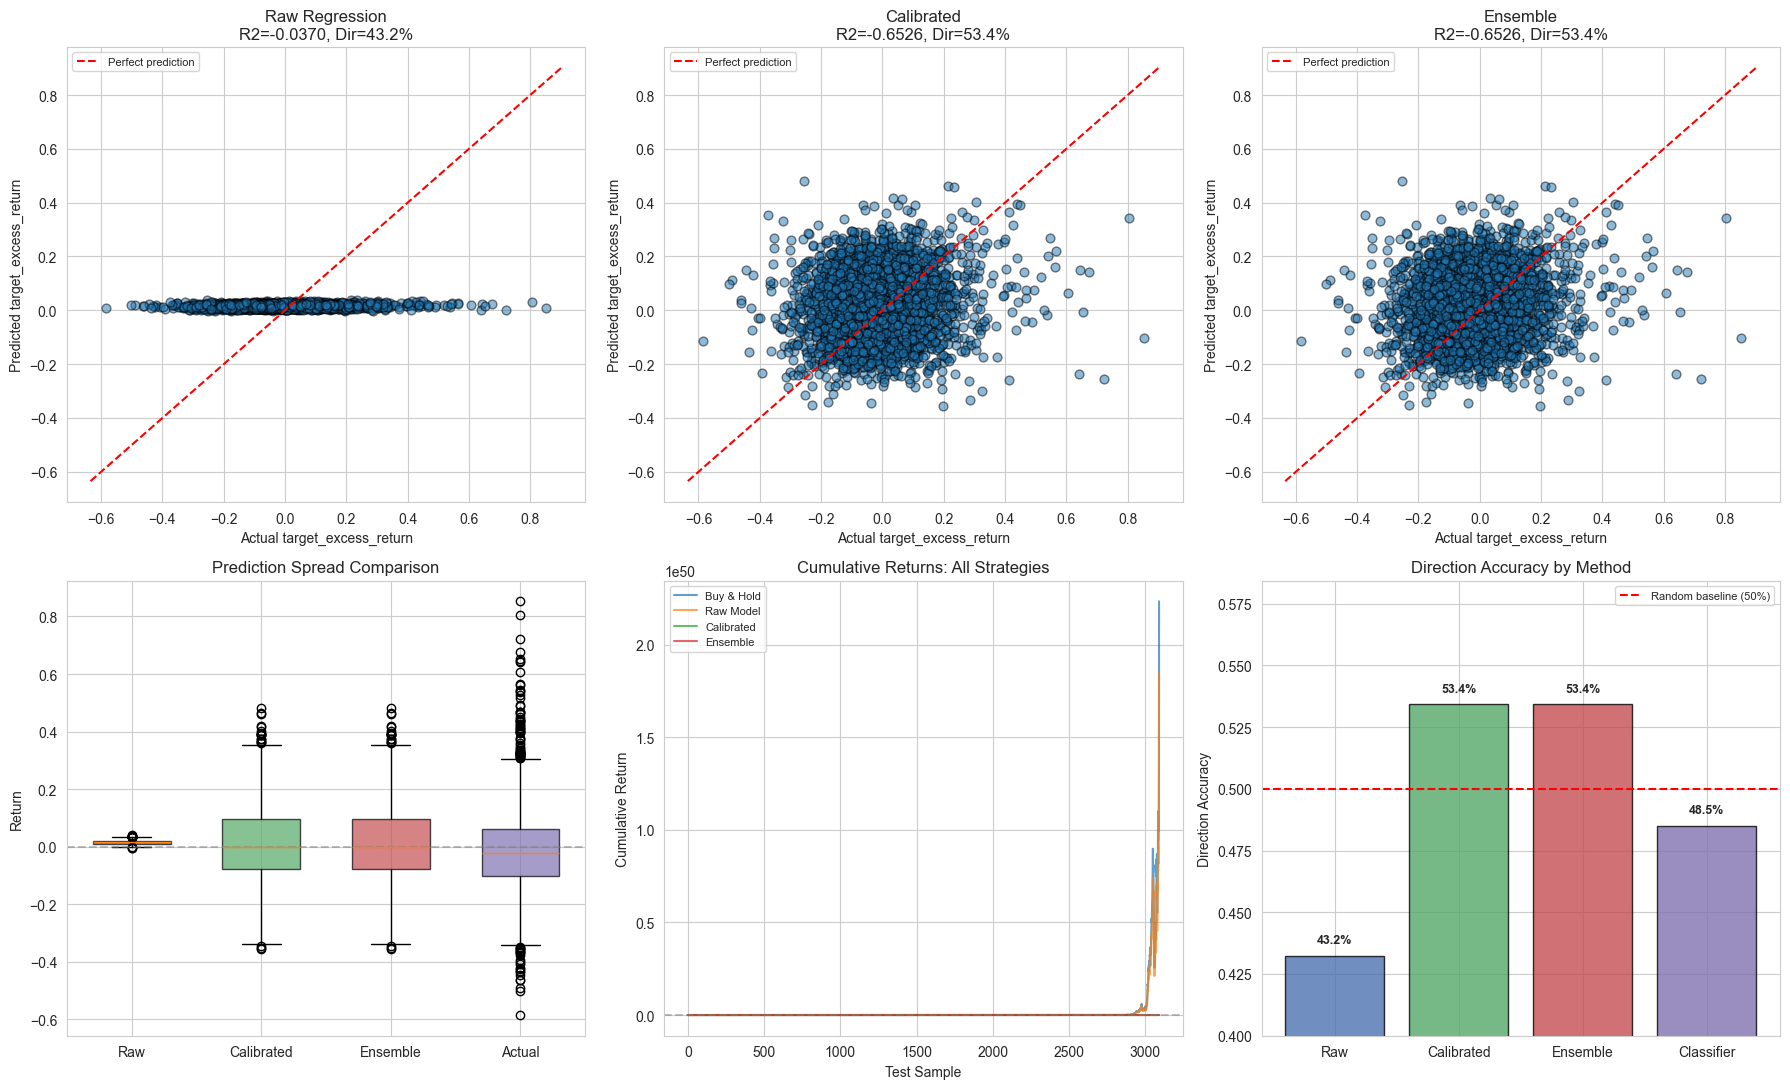

In [4]:
# Cell 4: Prediction Analysis - All Variants

if has_variants:
    fig, axes = plt.subplots(2, 3, figsize=(18, 11))

    # Row 1: Scatter plots - Raw vs Calibrated vs Ensemble
    scatter_data = [
        (y_pred_test, 'Raw Regression', axes[0, 0]),
        (y_pred_calibrated, 'Calibrated', axes[0, 1]),
        (y_pred_ensemble, 'Ensemble', axes[0, 2]),
    ]
    for preds, title, ax in scatter_data:
        ax.scatter(y_test, preds, alpha=0.5, edgecolor='black', s=40)
        lims = [min(y_test.min(), preds.min()) - 0.05,
                max(y_test.max(), preds.max()) + 0.05]
        ax.plot(lims, lims, 'r--', label='Perfect prediction')
        ax.set_xlabel(f'Actual {target_col}')
        ax.set_ylabel(f'Predicted {target_col}')
        r2 = r2_score(y_test, preds)
        dir_acc = np.mean(np.sign(y_test) == np.sign(preds))
        ax.set_title(f'{title}\nR2={r2:.4f}, Dir={dir_acc:.1%}')
        ax.legend(fontsize=8)

    # Row 2, Col 1: Prediction spread comparison
    ax = axes[1, 0]
    spread_data = {'Raw': y_pred_test, 'Calibrated': y_pred_calibrated,
                   'Ensemble': y_pred_ensemble, 'Actual': y_test}
    positions = list(range(len(spread_data)))
    bp = ax.boxplot(spread_data.values(), positions=positions, widths=0.6,
                    patch_artist=True, labels=spread_data.keys())
    colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.set_ylabel('Return')
    ax.set_title('Prediction Spread Comparison')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    # Row 2, Col 2: Cumulative returns comparison
    ax = axes[1, 1]
    if len(test_raw_returns) > 0:
        # Buy & hold
        buy_hold = np.cumprod(1 + test_raw_returns) - 1
        ax.plot(range(len(buy_hold)), buy_hold, label='Buy & Hold', alpha=0.7)

        # Raw model strategy
        raw_strategy = np.where(y_pred_test > 0, test_raw_returns, 0)
        ax.plot(range(len(raw_strategy)), np.cumprod(1 + raw_strategy) - 1,
                label='Raw Model', alpha=0.7)

        # Calibrated strategy
        cal_strategy = np.where(y_pred_calibrated > 0, test_raw_returns, 0)
        ax.plot(range(len(cal_strategy)), np.cumprod(1 + cal_strategy) - 1,
                label='Calibrated', alpha=0.7)

        # Ensemble strategy
        ens_strategy = np.where(y_pred_ensemble > 0, test_raw_returns, 0)
        ax.plot(range(len(ens_strategy)), np.cumprod(1 + ens_strategy) - 1,
                label='Ensemble', alpha=0.7)

        ax.set_xlabel('Test Sample')
        ax.set_ylabel('Cumulative Return')
        ax.set_title('Cumulative Returns: All Strategies')
        ax.legend(fontsize=8)
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    # Row 2, Col 3: Direction accuracy bar chart
    ax = axes[1, 2]
    method_names = ['Raw', 'Calibrated', 'Ensemble']
    dir_accs = [
        np.mean(np.sign(y_test) == np.sign(y_pred_test)),
        np.mean(np.sign(y_test) == np.sign(y_pred_calibrated)),
        np.mean(np.sign(y_test) == np.sign(y_pred_ensemble)),
    ]
    if len(dir_probs) > 0:
        method_names.append('Classifier')
        y_pred_dir = (dir_probs > 0.5).astype(float)
        y_true_dir = (y_test > 0).astype(float)
        dir_accs.append(np.mean(y_pred_dir == y_true_dir))

    bar_colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2'][:len(method_names)]
    bars = ax.bar(method_names, dir_accs, color=bar_colors, alpha=0.8, edgecolor='black')
    ax.axhline(y=0.5, color='red', linestyle='--', label='Random baseline (50%)')
    ax.set_ylabel('Direction Accuracy')
    ax.set_title('Direction Accuracy by Method')
    ax.legend(fontsize=8)
    ax.set_ylim(0.4, max(dir_accs) + 0.05)
    for bar, acc in zip(bars, dir_accs):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{acc:.1%}', ha='center', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join('..', 'results', 'prediction_analysis.png'),
                dpi=150, bbox_inches='tight')
    plt.show()

else:
    # Fallback: original 2x2 layout for old results without variants
    fig, axes = plt.subplots(2, 2, figsize=(15, 11))

    axes[0, 0].scatter(y_test, y_pred_test, alpha=0.5, edgecolor='black', s=40)
    lims = [min(y_test.min(), y_pred_test.min()) - 0.05,
            max(y_test.max(), y_pred_test.max()) + 0.05]
    axes[0, 0].plot(lims, lims, 'r--', label='Perfect prediction')
    axes[0, 0].set_xlabel(f'Actual {target_col}')
    axes[0, 0].set_ylabel(f'Predicted {target_col}')
    axes[0, 0].set_title('Predicted vs Actual (Test Set)')
    axes[0, 0].legend()

    residuals = y_test - y_pred_test
    axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 1].axvline(x=0, color='red', linestyle='--')
    axes[0, 1].set_xlabel('Prediction Error')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Prediction Errors')

    company_returns = dataset.groupby('ticker')['target_return'].mean().sort_values()
    colors = ['salmon' if v < 0 else 'steelblue' for v in company_returns.values]
    axes[1, 0].barh(company_returns.index, company_returns.values, color=colors)
    axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
    axes[1, 0].set_xlabel('Average Quarterly Return')
    axes[1, 0].set_title(f'Average Return by Company ({dataset["ticker"].nunique()} companies)')
    axes[1, 0].tick_params(axis='y', labelsize=7)

    if len(test_raw_returns) > 0:
        strategy_returns = np.where(y_pred_test > 0, test_raw_returns, 0)
        buy_hold = np.cumprod(1 + test_raw_returns) - 1
        strategy = np.cumprod(1 + strategy_returns) - 1
        axes[1, 1].plot(range(len(buy_hold)), buy_hold, label='Buy & Hold', alpha=0.7)
        axes[1, 1].plot(range(len(strategy)), strategy, label='Model Strategy', alpha=0.7)
        axes[1, 1].set_xlabel('Test Sample')
        axes[1, 1].set_ylabel('Cumulative Return')
        axes[1, 1].set_title('Cumulative Returns: Model vs Buy & Hold')
        axes[1, 1].legend()
        axes[1, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig(os.path.join('..', 'results', 'prediction_analysis.png'),
                dpi=150, bbox_inches='tight')
    plt.show()

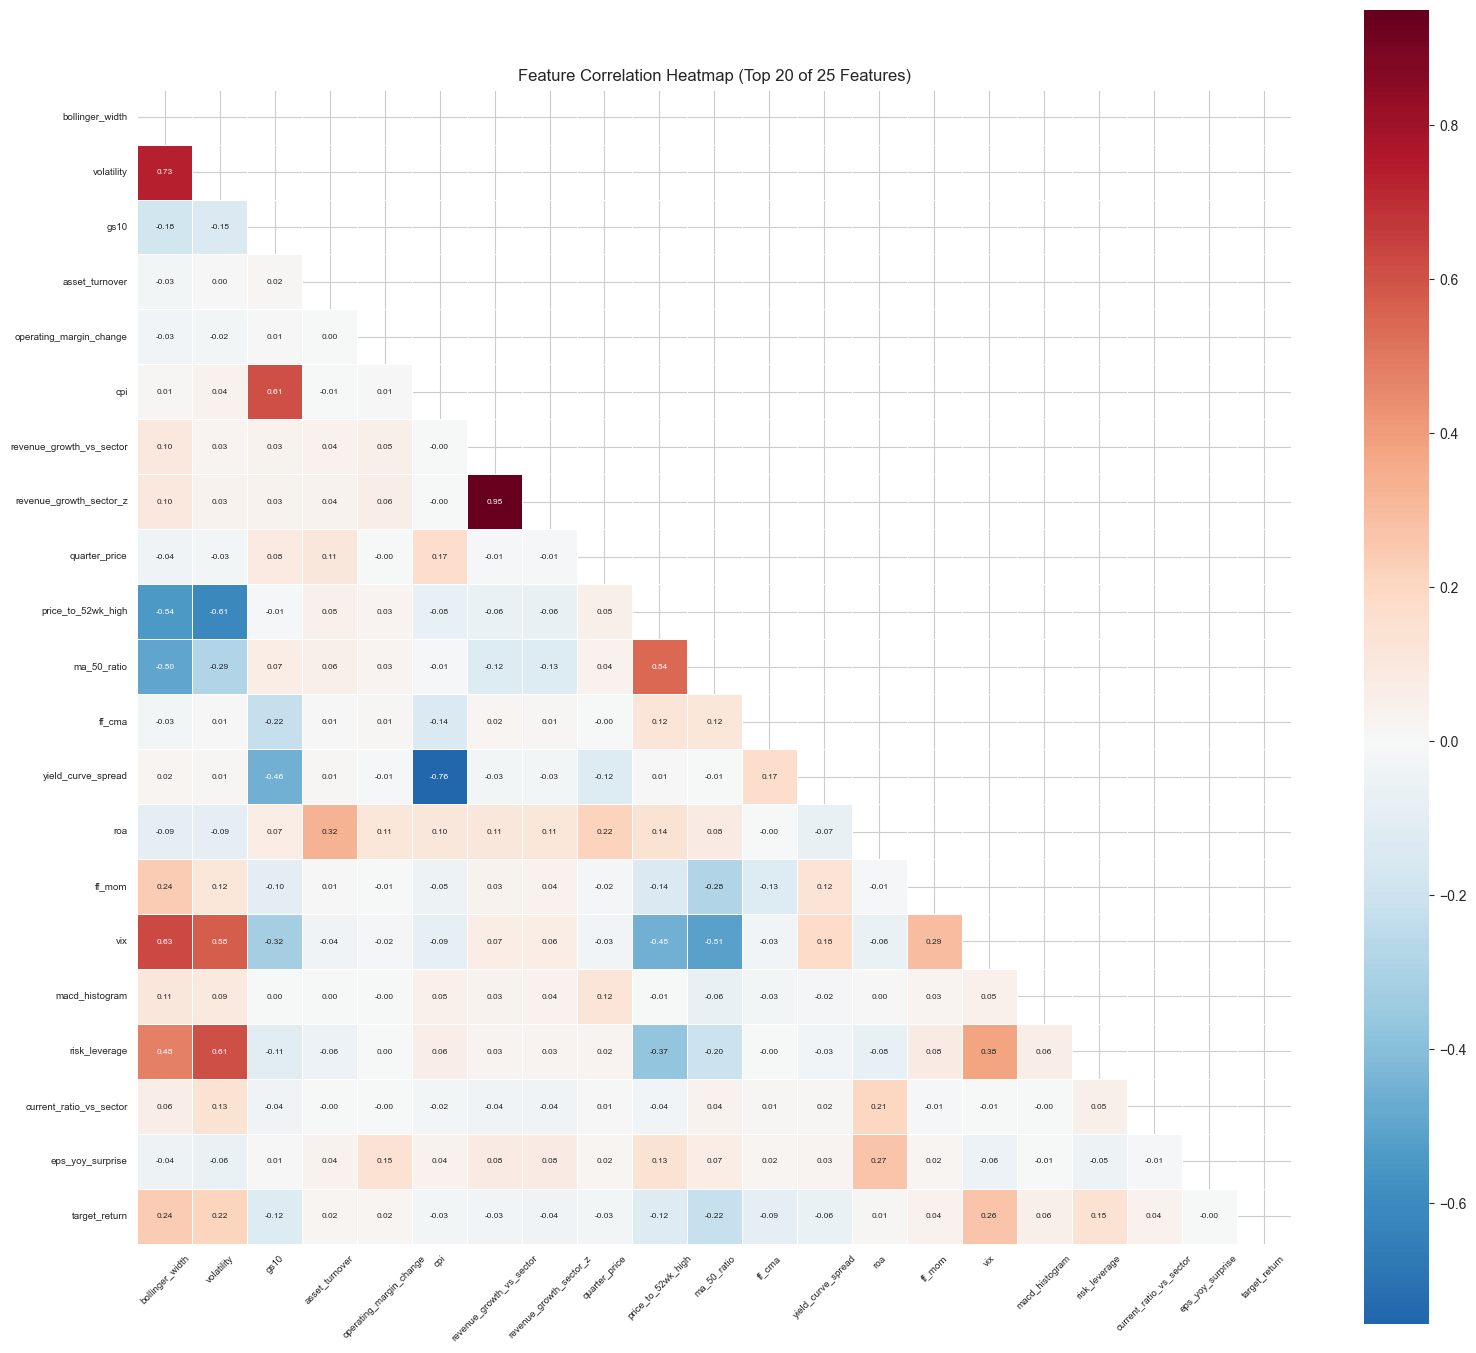

In [5]:
# Cell 5: Correlation Heatmap (top features only for readability)
# With 42 features, full heatmap is too dense - show top 20 most important
top_20 = importance.head(20)['feature'].tolist()
heatmap_cols = top_20 + ['target_return']

fig, ax = plt.subplots(figsize=(16, 14))
corr_matrix = dataset[heatmap_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt='.2f',
    cmap='RdBu_r', center=0, square=True,
    linewidths=0.5, ax=ax, annot_kws={'size': 6}
)
ax.set_title(f'Feature Correlation Heatmap (Top 20 of {len(feature_columns)} Features)')
ax.tick_params(axis='x', labelsize=7, rotation=45)
ax.tick_params(axis='y', labelsize=7)
plt.tight_layout()
plt.savefig(os.path.join('..', 'results', 'correlation_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

In [6]:
# Cell 6: Final Summary
print("=" * 65)
print("    PROJECT SUMMARY")
print("=" * 65)

target_label = "excess returns (vs S&P 500)" if target_col == 'target_excess_return' else "raw quarterly returns"

print(f"""
Stock Return Prediction using XGBoost
--------------------------------------
Objective: Predict {target_label}
           from financial fundamentals

Data:
  - {dataset['ticker'].nunique()} S&P 500 companies
  - {len(dataset)} company-quarter samples
  - Price data: Yahoo Finance via yfinance (2005-2026)
  - Financial data: Real SEC EDGAR quarterly filings
  - Macro data: FRED (Treasury, VIX, unemployment, GDP, CPI)
  - Sector data: Wikipedia S&P 500 GICS classifications
  - Benchmark: S&P 500 (SPY) for excess return calculation

Features ({len(feature_columns)} after selection):
  Fundamentals: revenue, profit_margin, operating_margin, eps, ROA, ROE, etc.
  Technical: MA 50/200 ratios, momentum, volatility, RSI, MACD, Bollinger, volume trend
  Macro: 10yr Treasury, VIX, unemployment, GDP, CPI
  Sector-relative: vs_sector (median-based) + sector z-scores
  Lag/change: quarter-over-quarter deltas for key metrics
  Interactions: momentum x quality, risk x leverage, growth x profitability

Model: XGBoost Regressor
  Loss function: Huber (pseudo-Huber)
  Scaler: RobustScaler (median/IQR-based)
  Split: Temporal (train on past, test on future)
  CV: 5-fold expanding-window time-series cross-validation
  Regression tuning: Optuna Bayesian optimization (150 trials) + early stopping
  Classifier tuning: Optuna Bayesian optimization (30 trials) + early stopping""")

if has_variants:
    print(f"""Prediction Methods:
  1. Raw Regression - Direct XGBoost output (Huber loss)
  2. Calibrated - Predictions scaled to match training data variance
  3. Classifier - Optuna-tuned XGBClassifier for up/down direction
  4. Ensemble - Blend of calibrated regression + classifier signal""")

print(f"""
Results:
  - Test RMSE: {metrics.get('test_rmse', 0):.4f}
  - Test R2: {metrics.get('test_r2', 0):.4f}
  - CV RMSE: {metrics.get('cv_rmse_mean', 0):.4f} (+/- {metrics.get('cv_rmse_std', 0):.4f})
  - Direction Accuracy: {metrics.get('direction_accuracy', 0):.1%}
  - Overfit Ratio: {metrics.get('overfit_ratio', 0):.2f}""")

if has_variants:
    cal_dir = np.mean(np.sign(y_test) == np.sign(y_pred_calibrated))
    ens_dir = np.mean(np.sign(y_test) == np.sign(y_pred_ensemble))
    # Spearman rank correlations
    from scipy.stats import spearmanr
    sp_raw, _ = spearmanr(y_test, y_pred_test)
    sp_cal, _ = spearmanr(y_test, y_pred_calibrated)
    print(f"  - Calibrated Direction Accuracy: {cal_dir:.1%}")
    print(f"  - Ensemble Direction Accuracy: {ens_dir:.1%}")
    print(f"  - Spearman Rank Correlation: Raw={sp_raw:.4f}, Calibrated={sp_cal:.4f}")
    print(f"  - Prediction Spread: Raw std={np.std(y_pred_test):.4f}, "
          f"Calibrated std={np.std(y_pred_calibrated):.4f}")

reg_trees = split_info.get('regression_trees', 'N/A')
clf_trees = split_info.get('classifier_trees', 'N/A')
print(f"""
Model Details:
  - Regression: {reg_trees} trees (from early stopping)
  - Classifier: {clf_trees} trees (Optuna-tuned, early stopping)

Key Improvements (v5):
  - Extended data back to 2005 (captures 2008 financial crisis)
  - Sector-relative features using median + z-scores (8 metrics)
  - Feature interactions (momentum x quality, risk x leverage, growth x profitability)
  - Lag/change features (quarter-over-quarter momentum signals)
  - Excess return target (isolates company alpha from market direction)
  - Optuna-tuned direction classifier (30 trials + early stopping)
  - Spearman rank correlation metric (measures ranking ability)
""")

print("All results saved to results/ folder.")
print("Project complete!")

    PROJECT SUMMARY

Stock Return Prediction using XGBoost
--------------------------------------
Objective: Predict excess returns (vs S&P 500)
           from financial fundamentals

Data:
  - 436 S&P 500 companies
  - 10813 company-quarter samples
  - Price data: Yahoo Finance via yfinance (2005-2026)
  - Financial data: Real SEC EDGAR quarterly filings
  - Macro data: FRED (Treasury, VIX, unemployment, GDP, CPI)
  - Sector data: Wikipedia S&P 500 GICS classifications
  - Benchmark: S&P 500 (SPY) for excess return calculation

Features (25 after selection):
  Fundamentals: revenue, profit_margin, operating_margin, eps, ROA, ROE, etc.
  Technical: MA 50/200 ratios, momentum, volatility, RSI, MACD, Bollinger, volume trend
  Macro: 10yr Treasury, VIX, unemployment, GDP, CPI
  Sector-relative: vs_sector (median-based) + sector z-scores
  Lag/change: quarter-over-quarter deltas for key metrics
  Interactions: momentum x quality, risk x leverage, growth x profitability

Model: XGBoost Reg